In [2]:
import os 
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pdb
from pyarrow import feather
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder

In [3]:
#move up in directory
os.chdir('../')

from helpers import dot2_

In [4]:
os.getcwd()

'C:\\Users\\Bio_Psych\\Desktop\\Deniz\\tf-cpu\\p1_generalization'

In [5]:
def plot_y_by_lag(coeff_array, title, ylab = 'Regression Weights'):
    coeff_array = np.transpose(coeff_array)
    stepsize = np.shape(coeff_array)[0]
    plt.plot(coeff_array,'-o', c = 'grey')
    plt.plot(np.mean(coeff_array, axis = 1),'-o', c = 'black')
    plt.ylabel(ylab)
    plt.xlabel('Lag (Trials)')
    plt.xticks(ticks = range(stepsize), labels = [int(i) for i in np.linspace(1, stepsize, num=stepsize)])
    plt.axhline(y=0, color='black', linestyle='--')
    plt.title(title)

In [ ]:

# load human data
path_to_data = 'data/human_raw_data/'
data_file = 'data_chakroun_wiehler.csv'
human_df = pd.read_csv(open(path_to_data + data_file, 'rb'), index_col=0)



# function outputs list of length len(stepsizes), which contain arrays of shifted by stepsize
def create_lagged_arrays(array, stepsizes):
    res = list()
    for s in stepsizes:
        x = np.array(pd.DataFrame(array).shift(int(s))[0]) # fill 999 missing values later
        # reshape for fitting
        x = x.reshape(-1,1)
        res.append(x)
    return(res)

#     d = pickle.load(open(path_to_data + data_file, 'rb'))
#     df = d.reset_index()

# create features and outcome
choices = np.array(df.choice)
rewards = np.array(df.reward)

all_coeffs = np.zeros([4,len(stepsizes)*2])

for c in range(4):

    my_choices = (choices == c).astype(int)


    # features
    past_choices = create_lagged_arrays((choices == c).astype(int), stepsizes)
    past_rewards = create_lagged_arrays(rewards, stepsizes)

    # fill na values
    past_choices = np.nan_to_num(past_choices, nan = 0)
    past_rewards = np.nan_to_num(past_rewards, nan = 0)

    # outcome
    y = choices == c

    # create multinomial model
    model = LogisticRegression()

    # stack lagged arrays horizontally
    for s,_ in enumerate(stepsizes):

        if s == 0:
            # create x
            x = (past_choices[s])
        else:
            # add to x
            x = np.hstack((x, past_choices[s]))

        # add interaction (past_choices * past_rewards)
        x = np.hstack((x, past_choices[s] * past_rewards[s].reshape(-1,1)))

    # fit
    model.fit(x, y)
    all_coeffs[c,:] = model.coef_

# get indices of choice coeffs
choice_coef_indices = (np.linspace(1,len(stepsizes)*2,len(stepsizes)*2)%2)==1

# get respective coeffs
choice_coeffs = all_coeffs[:,choice_coef_indices]
reward_coeffs = all_coeffs[:,choice_coef_indices==False]

# get means over all actions
#     weights = (list(choices).count(0)/len(choices), list(choices).count(1)/len(choices),
#               list(choices).count(2)/len(choices), list(choices).count(3)/len(choices))


choice_coeffs_means = np.average(choice_coeffs, axis = 0)
reward_coeffs_means = np.average(reward_coeffs, axis = 0)



In [133]:
def create_x1(df, stepsizes = np.linspace(1, 10, num=10)):

    # function outputs list of length len(stepsizes), which contain arrays of shifted by stepsize
    def create_lagged_arrays(array, stepsizes):
        res = list()
        for s in stepsizes:
            x = np.array(pd.DataFrame(array).shift(int(s))[0]) # fill 999 missing values later
            # reshape for fitting
            x = x.reshape(-1,1)
            res.append(x)
        return(res)

    #     d = pickle.load(open(path_to_data + data_file, 'rb'))
    #     df = d.reset_index()

    # create features and outcome
    choices = np.array(df.choice)
    rewards = np.array(df.reward)

    all_coeffs = np.zeros([4,len(stepsizes)*2])

    for c in range(4):

        my_choices = (choices == c).astype(int)


        # features
        past_choices = create_lagged_arrays((choices == c).astype(int), stepsizes)
        past_rewards = create_lagged_arrays(rewards, stepsizes)

        # fill na values
        past_choices = np.nan_to_num(past_choices, nan = 0)
        past_rewards = np.nan_to_num(past_rewards, nan = 0)

        # outcome
        y = choices == c

        # create multinomial model
        model = LogisticRegression()

        # stack lagged arrays horizontally
        for s,_ in enumerate(stepsizes):

            if s == 0:
                # create x
                x = (past_choices[s])
            else:
                # add to x
                x = np.hstack((x, past_choices[s]))

            # add interaction (past_choices * past_rewards)
            x = np.hstack((x, past_choices[s] * past_rewards[s].reshape(-1,1)))

        # fit
        model.fit(x, y)
        all_coeffs[c,:] = model.coef_

    # get indices of choice coeffs
    choice_coef_indices = (np.linspace(1,len(stepsizes)*2,len(stepsizes)*2)%2)==1

    # get respective coeffs
    choice_coeffs = all_coeffs[:,choice_coef_indices]
    reward_coeffs = all_coeffs[:,choice_coef_indices==False]

    # get means over all actions
#     weights = (list(choices).count(0)/len(choices), list(choices).count(1)/len(choices),
#               list(choices).count(2)/len(choices), list(choices).count(3)/len(choices))
    
    
    choice_coeffs_means = np.average(choice_coeffs, axis = 0)
    reward_coeffs_means = np.average(reward_coeffs, axis = 0)

    return(choice_coeffs_means, reward_coeffs_means)



In [130]:
# load human data

path_to_data = 'data/human_raw_data/'
data_file = 'data_chakroun_wiehler.csv'
human_df = pd.read_csv(open(path_to_data + data_file, 'rb'), index_col=0)

past_choice_means_h = []
past_reward_means_h = []

for sub in np.unique(human_df['vp']):

    temp_df = human_df[human_df['vp'].values==sub]
    # exclude choice == 0
    temp_df = temp_df[temp_df['choice'].values!=0]
    # get chosen reward
    chosen_reward = [[p1,p2,p3,p4][ch-1] for ch, p1, p2, p3, p4 in zip(temp_df['choice'], temp_df['reward_b1'], temp_df['reward_b2'], temp_df['reward_b3'], temp_df['reward_b4'])]
    temp_df['reward'] = np.divide(chosen_reward, 100)
    temp_df['choice'] = temp_df['choice'].values -1 # start actions from 0
    
    
    a, b = create_x1(df = temp_df)
    past_choice_means_h.append(a)
    past_reward_means_h.append(b)



0.0802675585284281

In [124]:
24/300

0.08

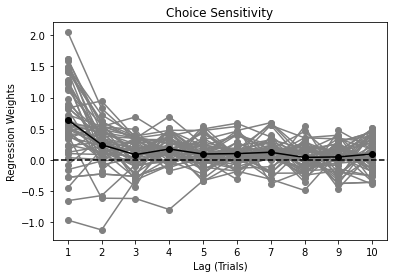

In [131]:
plot_y_by_lag(past_choice_means_h, title = 'Choice Sensitivity', ylab = 'Regression Weights')

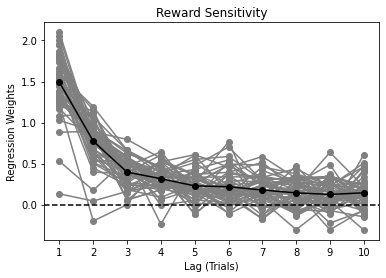

In [132]:
plot_y_by_lag(past_reward_means_h, title = 'Reward Sensitivity', ylab = 'Regression Weights')